<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/CNN_classifier_on_remote_sensing_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN(Resnet) classifier for landcover classification from remote sensing images

In this tasks, we will again use the same portion of the [SAT-6](https://csc.lsu.edu/~saikat/deepsat/) dataset from Louisiana State University and NASA Ames Research Center.

In this notebook, we will make use of small CNN network on the same subset of SAT-6 dataset that we used in the last exercise

In [3]:
# CNN classifier for landcover classification
# Author: Ankit Patnala, JSC, 2025
# Download necessary packages if right kernel is not present
# Not needed in colab
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Obtaining the data
The data is available via this B2share link [link](https://b2share.eudat.eu/records/89654eac10724d30a6c7e51f2c5422de). Download all the files at the same folder path where you are creating this notebook

Alternatively use the following wget commands to download the data

The following cell can be executed in Google colab

In [6]:
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

In [7]:
# load the csv file with the image data. Each row belongs to one sample. Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28 \times 28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
landcover_df

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,...,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,...,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,...,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,...,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,...,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,...,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,...,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,...,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,...,111,15,49,52,97,11,47,56,102,9


# Read annotation labels from different csv file

In [9]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


**Reminder :**  The data structure that you see above is called _one-hot encoding_


In [11]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
print(labels_df)
# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values

       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


# Plot random samples for illustration

&#x1F479; _Task:_ Plot few samples to see visually the data and gain more insights on how to reshape the 1d data to a 4 channel image (RGB & NIR)

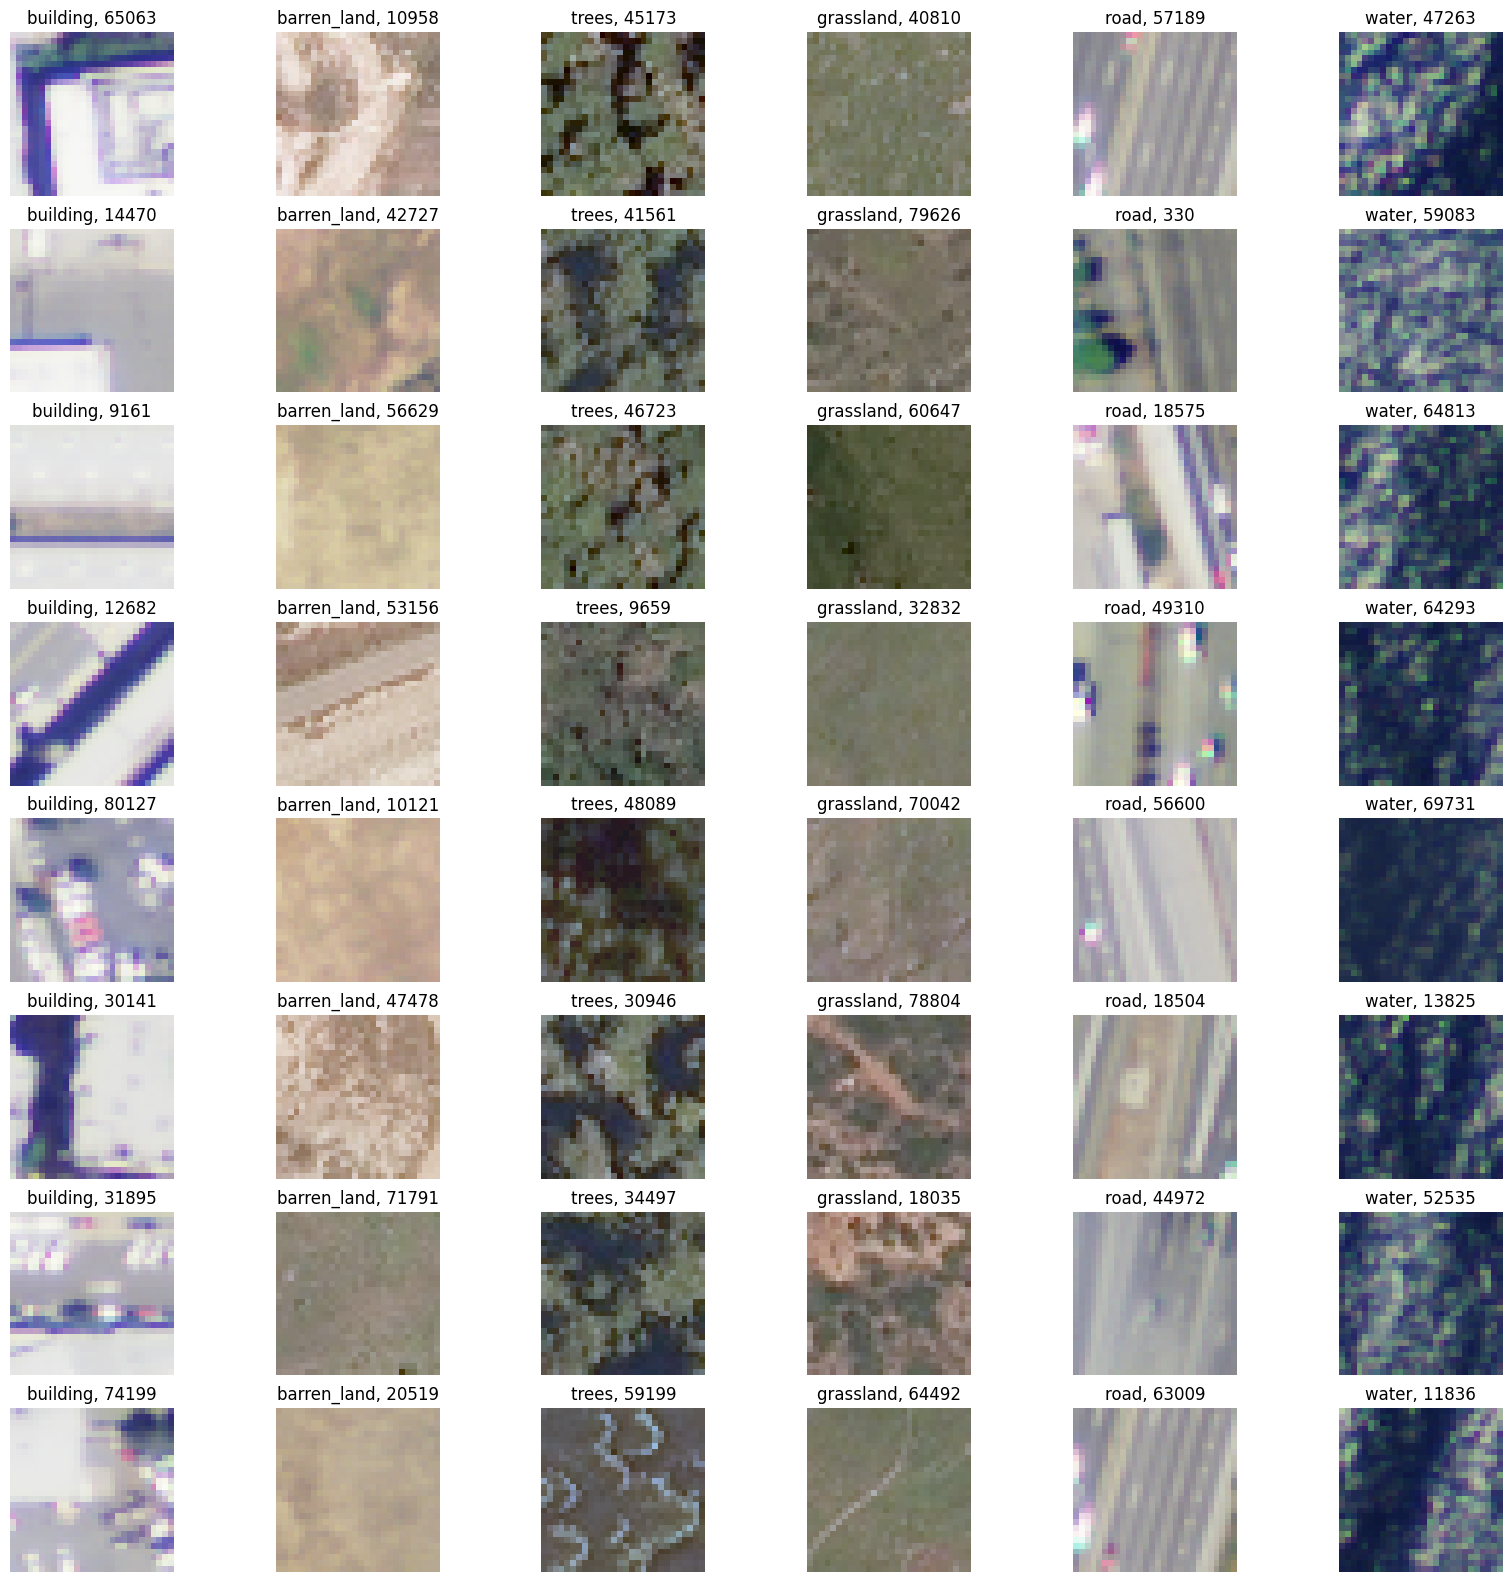

In [13]:
num_classes = len(column_names)
num_samples = 8  # number of rows to plot
sample_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_samples from this index list - make sure to avoid duplicates
    sample_idx.append(np.random.choice(np.where(class_idx.values)[0], size=num_samples, replace=False).tolist())

fig, ax = plt.subplots(num_samples, num_classes, figsize=(20,20))
for i in range(num_samples):
    for j in range(num_classes):
        data_index = sample_idx[j][i]
        ax[i,j].set_title(f"{labels[j]}, {data_index}")
        ax[i,j].axis('off')
        data = np.reshape(landcover_df.iloc[data_index].values,(-1,28,28,4))
        ax[i,j].imshow(data[0,...,:3])

### Create the training and test datasets

The dataset is not balanced. Use ***num_train*** and ***num_test*** as a definite integer number.

Note: the maximum we tried is ***num_train*** = 2000 and ***num_test*** = 200. Beyond that for some classes, we did not find that many samples

In case you want all samples for training then use ***num_train*** = -1

In [15]:
num_train = 2000 #replace with -1 if all samples need to be used for training
num_test = 300
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')


number of train indices: 11770, number of test indices: 1800


In [16]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

# Calculate Normalization Parameter using Train Dataset

In [18]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.04828, 132.14975, 129.32468, 121.14622], dtype=float32),
 array([55.2652  , 50.843193, 46.804512, 65.666534], dtype=float32))

## Define torch dataset

From here, we will make use of general workflow of PyTorch. First thing is to create a dataset. We are making use of mapped-style dataset. [Refer this page for more details](https://pytorch.org/docs/stable/data.html#map-style-datasets)

Important thing is to define the total length under dunder function *__len__* and data corresponding to the index under *__getitem__*

In [20]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [21]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

Now, we will use **torch.nn.Module** to build our CNN model.

**Important points:**

*   To build modules in a list use **torch.nn.ModuleList()** instead of native list.

*   Define **forward** function to define the step-byt-by mathematical transformation




Define the device (**GPU** if you use GPU as your runtime) else it will run on **CPU**)
Instatiation of the CNN model is also define in this cell

In [24]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

PyTorch version: 2.8.0.dev20250514+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 5070


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
# Load ResNet
resnet = models.resnet34(pretrained=False)

# Change channels in first layer from 3 to 4.
resnet.conv1 = nn.Conv2d(
    in_channels=4,    # 4 channels (R,G,B,NIR)
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

# Change the final fully connected layer to output 6 classes instead of 1000
resnet.fc = nn.Linear(resnet.fc.in_features, 6)

C:\Users\lasse\anaconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lasse\anaconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Define training parameters


*   Optimizer : This reulates the rate of learning. USe wither adam or SGD. For other optimizers, feel free to add them.
*   Scheduler : It updates the learning rate during the training process. We have commented here out. PLease feel free to play with it.
*   Loss function: As it is a multi-class classification problem, CrossEntropy is a suitable loss function.



In [28]:
optim = "adam"
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.0001) if optim == "adam" else torch.optim.SGD(resnet.parameters(),lr=0.1)
# reduce learning rate over time
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.95)
loss_fn = torch.nn.CrossEntropyLoss()

Previously, we have defined dataset which takes an index as a parameter and provides data corresponding to the index. In such deep learning problems, we process them in a batch. DataLoader takes control of such requirements by defining the paraemter such as **batch_size** and **shuffle**.

**Note:**


*   In training, we want each time to have different samples in a batch. The ***shuffle*=True** ensures that. For validation, we do not required such shuffling, hence it is set to False
*   We used the whole length of test dataset as it is small. Incase of any issue with large number of test samples, feel free to decrease the number such as $256$



In [30]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=512,shuffle=True,drop_last=False)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

# Training Routine
Define number of epochs for the training.


In [32]:
num_epochs = 500
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []
kappa_per_epoch = []

resnet = resnet.to(device)
with tqdm(total=num_epochs) as pbar:
    for i in range(num_epochs):
        resnet.train()
        for train_data_idx, train_data in enumerate(train_dataloader):
            optimizer.zero_grad()
            data, labels = train_data
            data = data.to(device)
            labels = labels.to(device)
            preds = resnet(data)
            train_loss = loss_fn(preds,labels)
            train_loss.backward()
            optimizer.step()
        training_loss_per_epoch.append(train_loss.item())

        resnet.eval()
        pred_labels = []
        true_labels = []
        pos_class_probs = [] 
        with torch.no_grad():
            for test_data_idx, test_data in enumerate(test_dataloader):
                data, labels = test_data
                data = data.to(device)
                labels = labels.to(device)
                preds = resnet(data)
                val_loss = loss_fn(preds,labels)
    
                probs = torch.softmax(preds, dim=1)  # or torch.sigmoid if model outputs single logit for binary
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                pos_class_probs.append(probs.cpu().numpy())
    
        validation_loss_per_epoch.append(val_loss.item())
        acc = accuracy_score(true_labels, pred_labels)
        acc_per_epoch.append(acc)
        kappa = cohen_kappa_score(true_labels, pred_labels)
        kappa_per_epoch.append(kappa)
        pos_class_probs = np.concatenate(pos_class_probs, axis=0)
        pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss: {train_loss:.4f}, validation_loss: {val_loss:.4f}, accuracy: {acc:.4f}, kappa: {kappa:.4f}")

Epoch 500/500: training_loss: 0.0000, validation_loss: 0.1521, accuracy: 0.9817, kappa: 0.9780:   0%| | 0/500 [06:08<?,


Lots of plots, 6 for the roc curves of each class and then accuracy and kappas. The model becomes good quite fast so there isnt much to see in any of the plots(as far as things to improve).

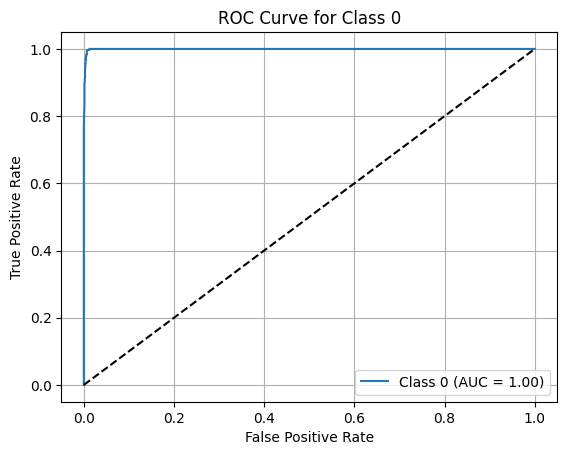

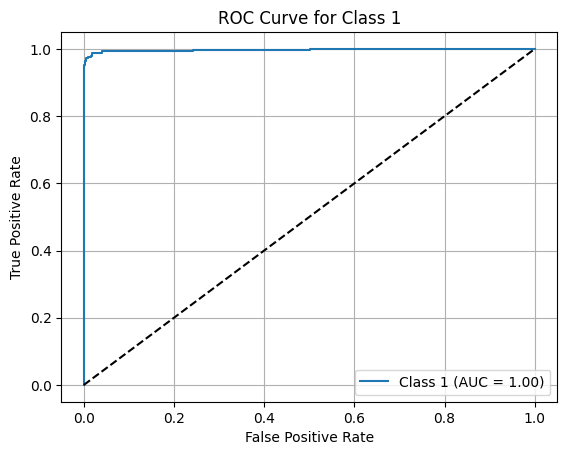

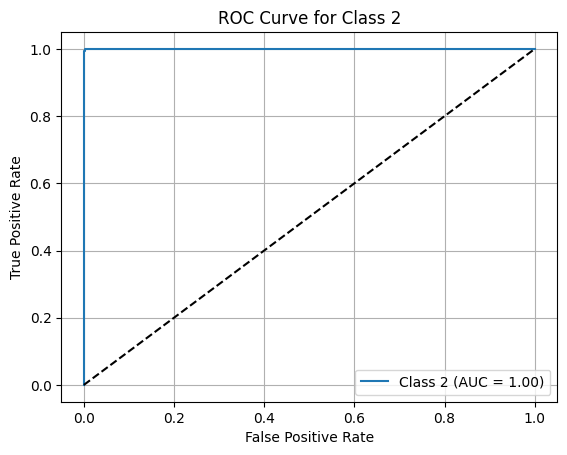

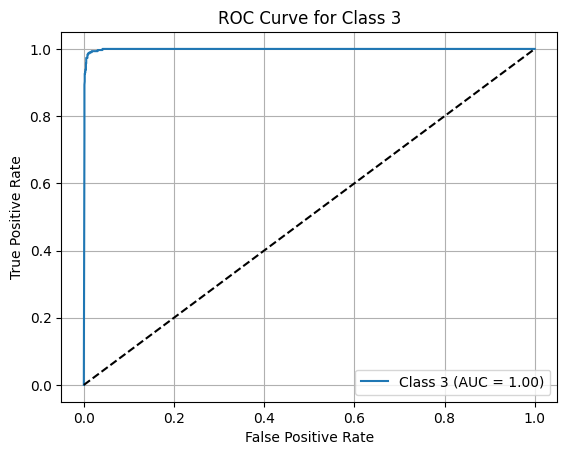

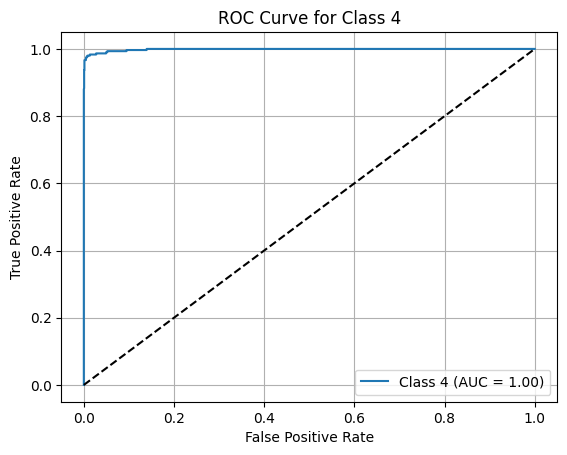

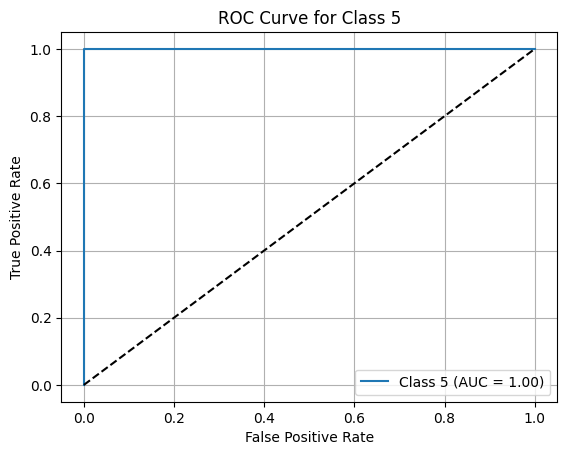

In [34]:
# Number of classes
n_classes = 6

# Binarize the labels
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pos_class_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

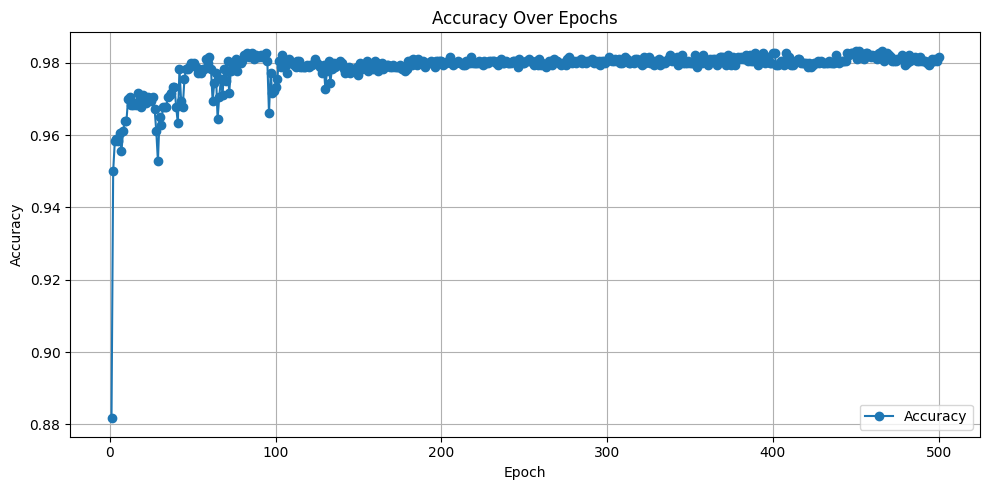

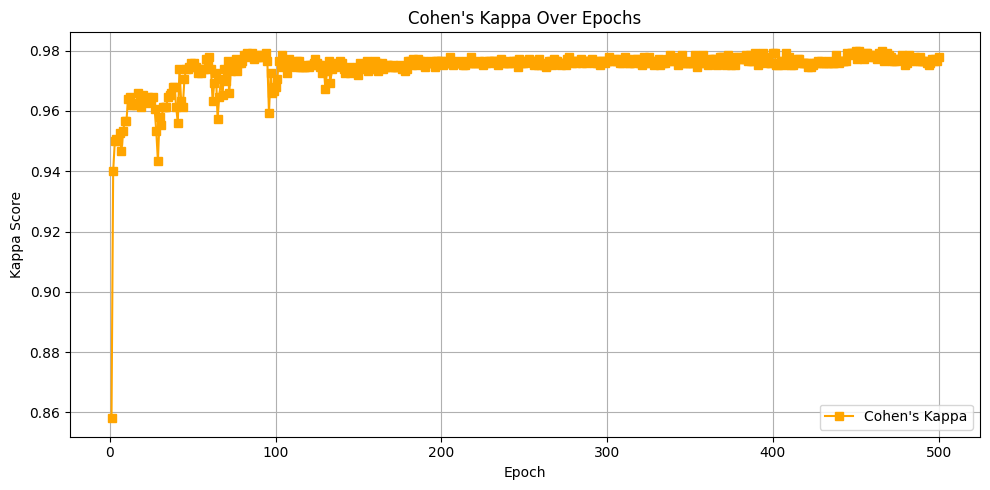

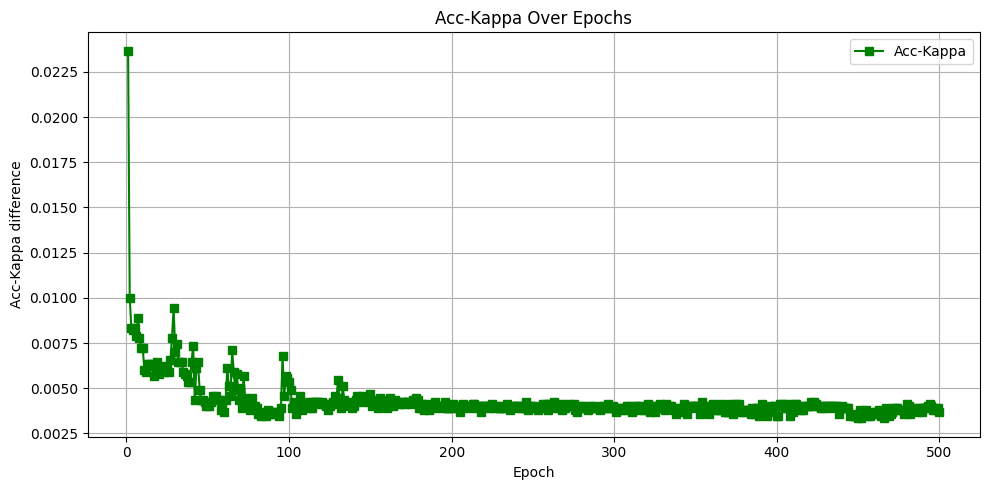

In [35]:
epochs = list(range(1, num_epochs + 1))

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc_per_epoch, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Cohen’s Kappa
plt.figure(figsize=(10, 5))
plt.plot(epochs, kappa_per_epoch, marker='s', color='orange', label='Cohen\'s Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Cohen\'s Kappa Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Acc and Kappa difference (Acc-Kappa)
acc_array = np.array(acc_per_epoch)
kappa_array = np.array(kappa_per_epoch)
diff = acc_array - kappa_array

plt.figure(figsize=(10, 5))
plt.plot(epochs, diff, marker='s', color='green', label='Acc-Kappa')
plt.xlabel('Epoch')
plt.ylabel('Acc-Kappa difference')
plt.title('Acc-Kappa Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()